In [3]:
# ── Cell 1: Install dependencies ────────────────────────────
!pip install datasets -q

In [8]:
# ── Cell 2: Load the dataset ────────────────────────────────
from datasets import DatasetDict, load_dataset

BASE = "https://huggingface.co/datasets/conll2003/resolve/refs%2Fconvert%2Fparquet/conll2003"

dataset = DatasetDict({
    split: load_dataset("parquet", data_files={split: f"{BASE}/{split}/0000.parquet"}, split=split)
    for split in ["train", "validation", "test"]
})

conll2003/train/0000.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

0000.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

Generating validation split: 0 examples [00:00, ? examples/s]

0000.parquet:   0%|          | 0.00/283k [00:00<?, ?B/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [9]:
# ── Cell 3: Inspect label mappings ──────────────────────────
# NER tags follow the BIO (IOB2) scheme
ner_feature = dataset["train"].features["ner_tags"]
ner_labels  = ner_feature.feature.names   # list of tag strings
print("NER labels:", ner_labels)

pos_labels   = dataset["train"].features["pos_tags"].feature.names
chunk_labels = dataset["train"].features["chunk_tags"].feature.names
print("POS labels:", pos_labels)
print("Chunk labels:", chunk_labels)

NER labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
POS labels: ['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
Chunk labels: ['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP']


In [10]:
# ── Cell 4: Peek at a single example ────────────────────────
example = dataset["train"][0]

print(f"{'Token':<15} {'POS':<8} {'Chunk':<12} {'NER'}")
print("-" * 45)
for token, pos, chunk, ner in zip(
    example["tokens"],
    example["pos_tags"],
    example["chunk_tags"],
    example["ner_tags"],
):
    print(f"{token:<15} {pos_labels[pos]:<8} {chunk_labels[chunk]:<12} {ner_labels[ner]}")

Token           POS      Chunk        NER
---------------------------------------------
EU              NNP      B-NP         B-ORG
rejects         VBZ      B-VP         O
German          JJ       B-NP         B-MISC
call            NN       I-NP         O
to              TO       B-VP         O
boycott         VB       I-VP         O
British         JJ       B-NP         B-MISC
lamb            NN       I-NP         O
.               .        O            O


In [11]:
# ── Cell 5: Split sizes ──────────────────────────────────────
for split in ["train", "validation", "test"]:
    n_tokens = sum(len(x["tokens"]) for x in dataset[split])
    print(f"{split:>12}: {len(dataset[split]):>5} sentences, {n_tokens:>7} tokens")

       train: 14041 sentences,  203621 tokens
  validation:  3250 sentences,   51362 tokens
        test:  3453 sentences,   46435 tokens


In [12]:
# ── Cell 6: NER label distribution (train set) ──────────────
from collections import Counter
import pandas as pd

counter = Counter()
for example in dataset["train"]:
    for tag_id in example["ner_tags"]:
        counter[ner_labels[tag_id]] += 1

df = (
    pd.DataFrame(counter.most_common(), columns=["Tag", "Count"])
    .assign(Pct=lambda d: (d["Count"] / d["Count"].sum() * 100).round(2))
)
print(df.to_string(index=False))

   Tag  Count   Pct
     O 169578 83.28
 B-LOC   7140  3.51
 B-PER   6600  3.24
 B-ORG   6321  3.10
 I-PER   4528  2.22
 I-ORG   3704  1.82
B-MISC   3438  1.69
 I-LOC   1157  0.57
I-MISC   1155  0.57


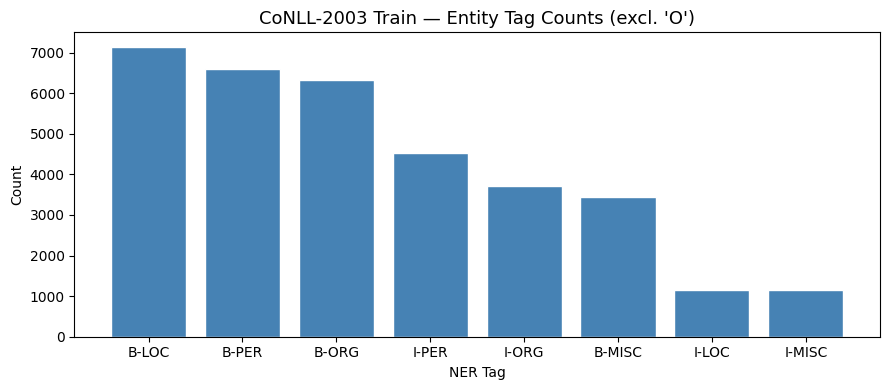

In [14]:
# ── Cell 7: Visualise the distribution ──────────────────────
import matplotlib.pyplot as plt

entity_df = df[df["Tag"] != "O"].copy()   # drop the Outside tag for clarity

fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(entity_df["Tag"], entity_df["Count"], color="steelblue", edgecolor="white")
ax.set_title("CoNLL-2003 Train — Entity Tag Counts (excl. 'O')", fontsize=13)
ax.set_xlabel("NER Tag")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

In [15]:
# ── Cell 8: Sample sentences for each entity type ───────────
def sentences_with_entity(split, entity_label, n=3):
    """Return n sentences that contain at least one token of entity_label."""
    label_id = ner_labels.index(entity_label)
    results = []
    for ex in dataset[split]:
        if label_id in ex["ner_tags"]:
            results.append(ex["tokens"])
            if len(results) == n:
                break
    return results

for entity in ["B-PER", "B-ORG", "B-LOC", "B-MISC"]:
    print(f"\n── {entity} ──")
    for tokens in sentences_with_entity("train", entity, n=2):
        print(" ".join(tokens))


── B-PER ──
Peter Blackburn
Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .

── B-ORG ──
EU rejects German call to boycott British lamb .
The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .

── B-LOC ──
BRUSSELS 1996-08-22
Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .

── B-MISC ──
EU rejects German call to boycott British lamb .
The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .
